<h1>Computer Vision and Image Processing</h1>
<h2>Fruit Inspection - Final Challenge</h2>
<h4>Alex Gianelli<br/>Andrea Castronovo</h4>

In this document we will develop an Image Processing routine in order to solve the Final Challenge of a University Computer Vision project (<a href="./fruit-inspection.pdf">file</a>).

The target images are the following:
<ul>
    <li><a href="./final challenge/C1_000006.png">Image 06</a></li>
    <li><a href="./final challenge/C1_000007.png">Image 07</a></li>
    <li><a href="./final challenge/C1_000008.png">Image 08</a></li>
    <li><a href="./final challenge/C1_000009.png">Image 09</a></li>
    <li><a href="./final challenge/C1_000010.png">Image 10</a></li>
</ul>

<b>NIR</b> versions of the same images are also provided:
<ul>
    <li><a href="./final challenge/C0_000006.png">Image 06</a></li>
    <li><a href="./final challenge/C0_000007.png">Image 07</a></li>
    <li><a href="./final challenge/C0_000008.png">Image 08</a></li>
    <li><a href="./final challenge/C0_000009.png">Image 09</a></li>
    <li><a href="./final challenge/C0_000010.png">Image 10</a></li>
</ul>
<br/>

The objectives of this task are:
<ul>
    <li><b>Segment</b> the fruit: special care should be taken to remove  as “background” the dirt on the conveyor as well as the sticker in Image 06. </li>
    <li>Search for the <b>defects</b> on Image 07.</li>
</ul>


We advise to <b><i>Run All</i></b> the scripts before reading the document, for a better understanding of the report.
<br/><br/>
The code begins by importing all the necessary libraries/packages.

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

<b>Choose the target image <i>HERE</i></b>.

In [53]:
# Chose the image HERE (6-10)
IMG = 6

We import both the colored image and the NIR. In this task we will focus on the NIR and we will show the result on the colored image.

<b>Important note</b>: the image couples are not aligned, we considered alignment but we decided it was not useful for this task.

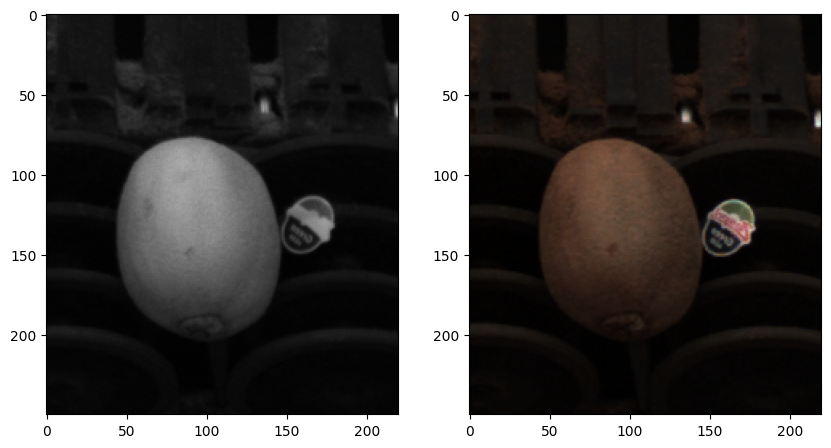

In [54]:
if(IMG==10):
    path = ''
else:
    path = '0'

img_gray = cv2.imread('final challenge/C0_0000' + path + str(IMG) + ".png", cv2.IMREAD_GRAYSCALE)
img_bgr = cv2.imread('final challenge/C1_0000' + path + str(IMG) + ".png")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2, figsize = (10,10))
axarr[0].imshow(img_gray,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(img_rgb)
plt.show()

<h3>Fruit Segmentation</h3>

Firstly, we focused on <a href="./final challenge/C0_000006.png">Image 06</a> trying to find a method to remove the sticker without disturbing all other images. Thresholding on the RGB image wouldn't work, so after some attempts we decided to use the <b>h-channel</b> of the <b>HLS</b> color space, using <b>OTSU</b> combined with <b>BINARY</b> and managed to remove the sticker; to do this we applied <b>Gaussian</b> and <b>Median Blur</b> filter before thresholding.

This generated a binary mask without any specified threshold and this mask was able to remove only the sticker. (some kiwi edges have tiny dents but we considered this irrilevant)

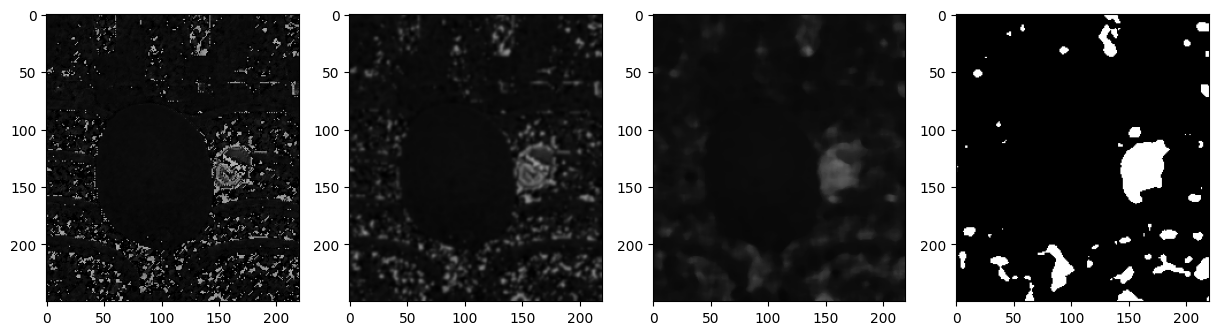

In [55]:
sigma = 1.2
k_size = int(np.ceil((3*sigma))*2 + 1)

img_spet = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HLS)
h, l, s = cv2.split(img_spet)

h_gf = cv2.GaussianBlur(h, (k_size,k_size), sigma)
h_mf = cv2.medianBlur(h_gf, k_size)

_, mask = cv2.threshold(h_mf, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

f, axarr = plt.subplots(1,4, figsize = (15,15))
axarr[0].imshow(h,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(h_gf,cmap='gray',vmin=0, vmax=255)
axarr[2].imshow(h_mf,cmap='gray',vmin=0, vmax=255)
axarr[3].imshow(mask,cmap='gray',vmin=0, vmax=255)
plt.show()

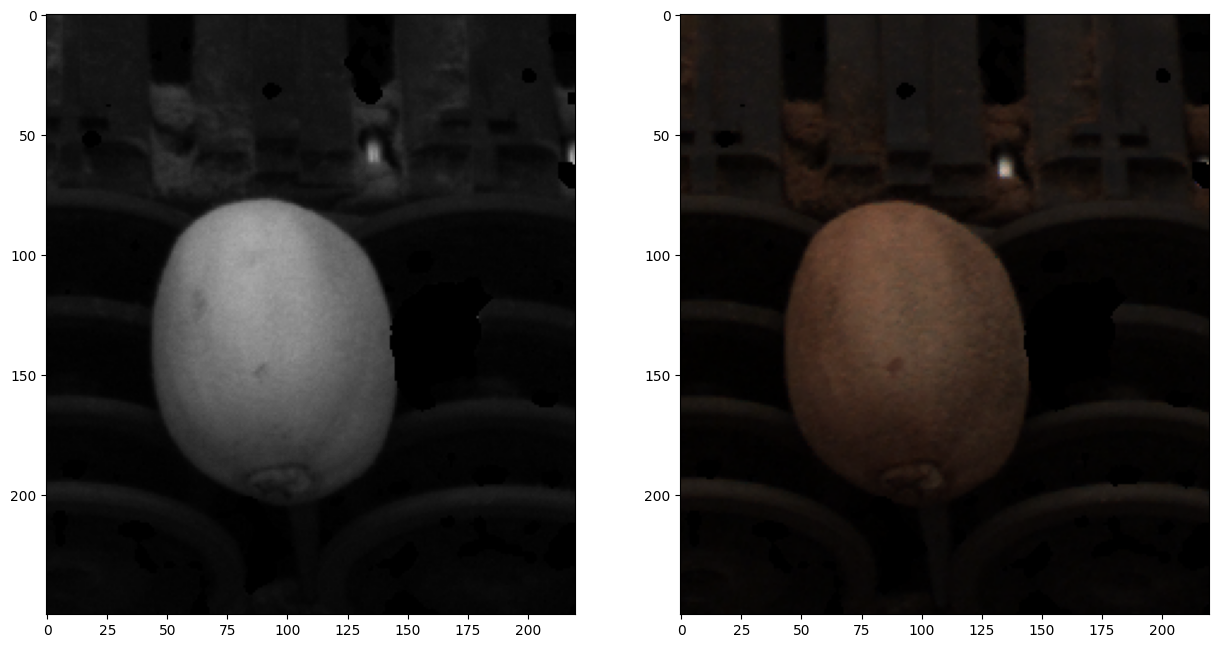

In [56]:
background = np.zeros_like(img_gray)

sticker_clean_nir = np.where(mask==np.array([0]), img_gray, background)

masked=cv2.bitwise_and(img_rgb,img_rgb,mask=sticker_clean_nir)

f, axarr = plt.subplots(1,2, figsize = (15,12))
axarr[0].imshow(sticker_clean_nir,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(masked,vmin=0, vmax=255)
plt.show()

Now, we need to find a <b>Binary Mask</b> to remove the remaining background.

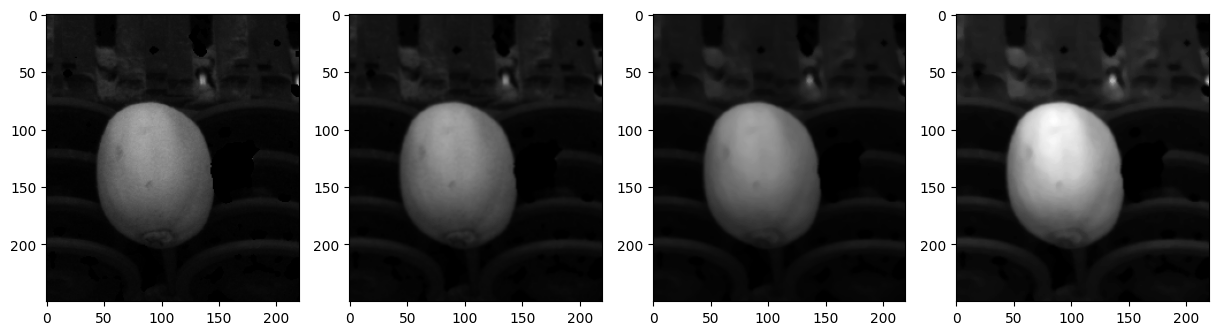

In [57]:
nir_gf = cv2.GaussianBlur(sticker_clean_nir, (5,5), .8)
nir_mf = cv2.medianBlur(nir_gf, 5)

nir_fnorm = cv2.normalize(nir_mf, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

f, axarr = plt.subplots(1,4, figsize = (15,12))
axarr[0].imshow(sticker_clean_nir,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(nir_gf,cmap='gray',vmin=0, vmax=255)
axarr[2].imshow(nir_mf,cmap='gray',vmin=0, vmax=255)
axarr[3].imshow(nir_fnorm,cmap='gray',vmin=0, vmax=255)
plt.show()

As seen above the <b>Normalization</b> of the filtered image (Gaussian and Median blur) shows off more contrast on the edges. We can proceed with Canny to find the edges of the fruit, finding all contours we sorted on area to catch only the border of the fruit.

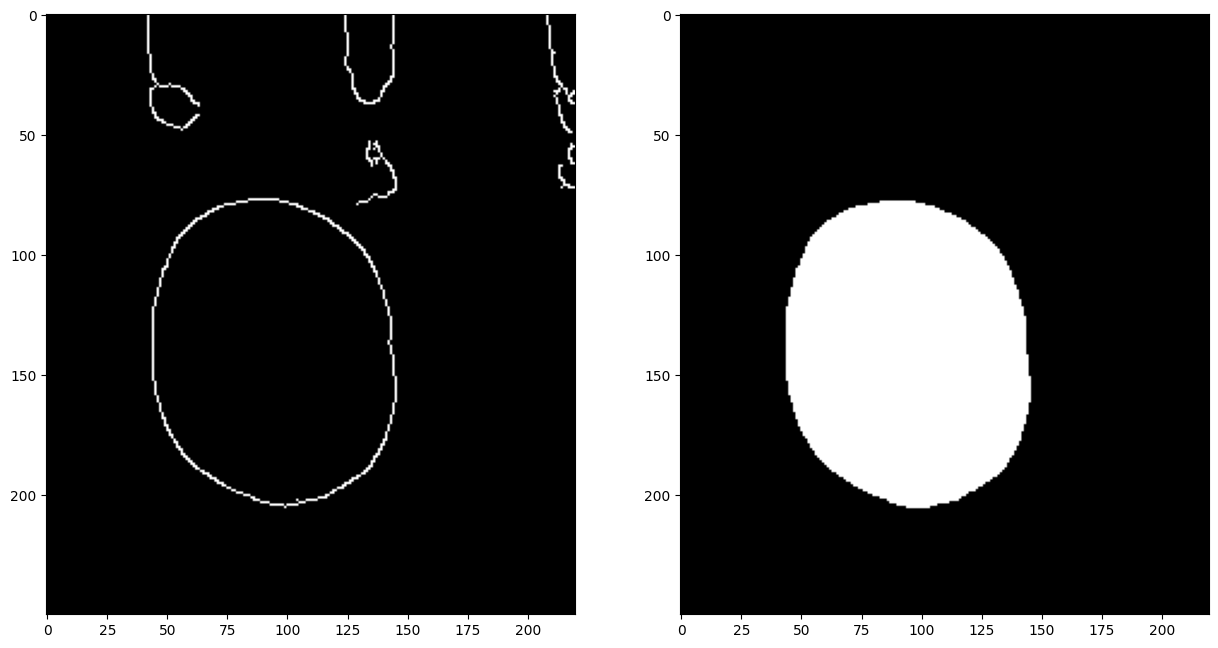

In [58]:
edge = cv2.Canny(nir_fnorm, 40, 150)

# Binarization
edge[edge<255] = 0

ellipse_34 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 4))
edge_morph = cv2.morphologyEx(edge, cv2.MORPH_CLOSE, ellipse_34)

# Get all contours
contours, _ = cv2.findContours(edge_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# and sorted them for area (decreasing)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

mask = np.zeros_like(img_gray)
ext_edge = np.zeros_like(img_gray)
cv2.drawContours(mask, [contours[0]], -1, (255), thickness=cv2.FILLED)
cv2.drawContours(ext_edge, [contours[0]], -1, (255), thickness=3)

f, axarr = plt.subplots(1,2, figsize = (15,12))
axarr[0].imshow(edge,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(mask,cmap='gray',vmin=0, vmax=255)
plt.show()

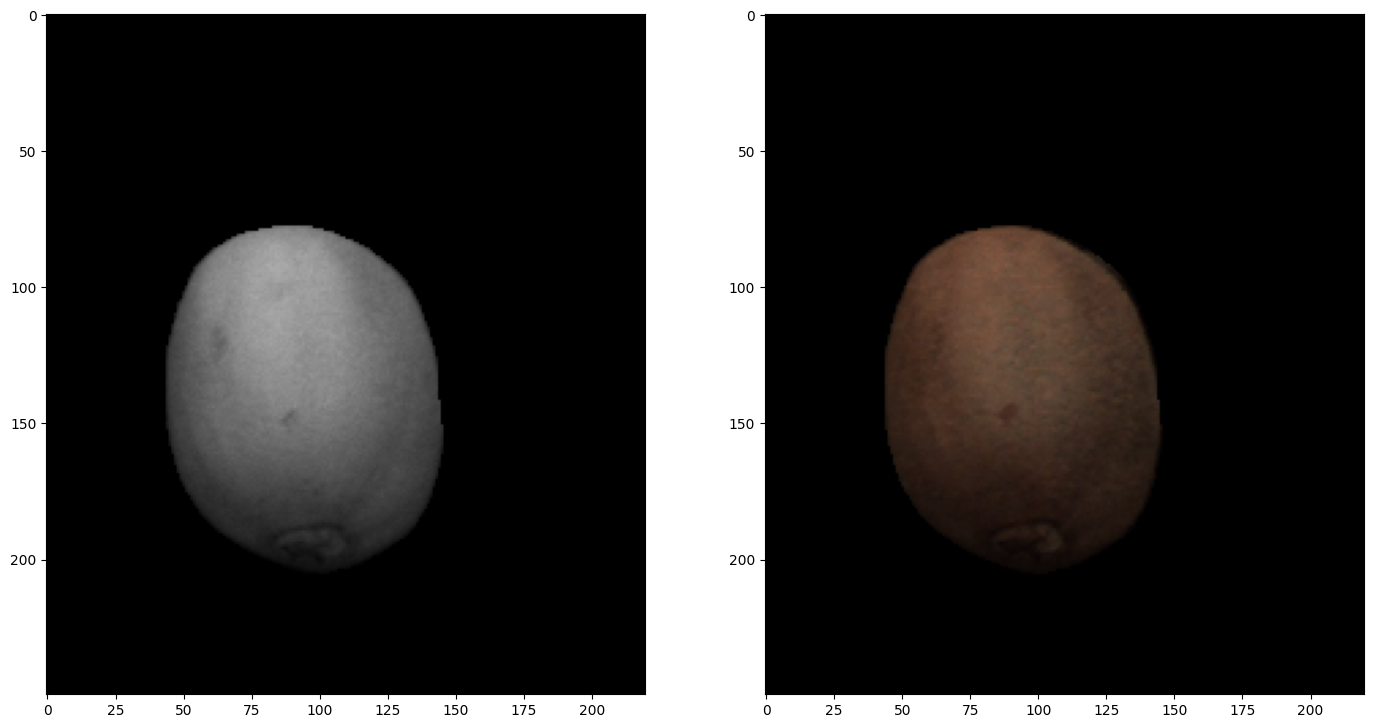

In [59]:
# Inverted mask for outline fruit
mask = cv2.bitwise_not(mask)

background = np.zeros_like(img_gray)

bg_clean_nir = np.where(mask==np.array([0]), img_gray, background)

# Outline fruit
out_fruit = bg_clean_nir & img_gray

bg_clear_rgb = cv2.bitwise_and(img_rgb,img_rgb,mask=bg_clean_nir)

f, axarr = plt.subplots(1,2,figsize= (17,15))
axarr[0].imshow(bg_clean_nir,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(bg_clear_rgb,vmin=0, vmax=255)
plt.show()

<h3>Search Defects</h3>

As seen in the previous tasks with Canny we able to find defects edges, if present, by applying it to the NIR image above and removing the external edge.

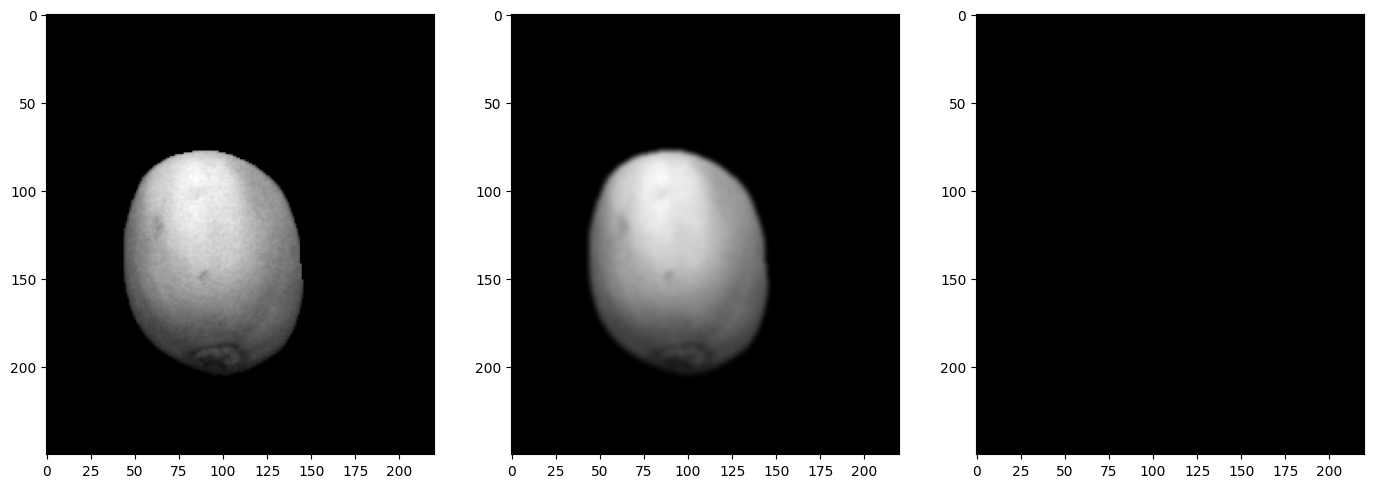

In [60]:
nir_clear_norm = cv2.normalize(bg_clean_nir, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

clear_gf = cv2.GaussianBlur(nir_clear_norm, (5,5), 1.45)

edge = cv2.Canny(clear_gf, 40, 150)

edge = np.where(ext_edge==255, background, edge)

ellipse_10 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))

edge_morph = cv2.morphologyEx(edge, cv2.MORPH_CLOSE, ellipse_10)

f, axarr = plt.subplots(1, 3, figsize= (17,15))
axarr[0].imshow(nir_clear_norm,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(clear_gf,cmap='gray',vmin=0, vmax=255)
axarr[2].imshow(edge_morph,cmap='gray',vmin=0, vmax=255)
plt.show()

We again opted for a similar kind of filters to rule out unwanted areas.

In [61]:
r, g, b = cv2.split(bg_clear_rgb)

contours, _ = cv2.findContours(edge_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Creat mask to contain defects
defects = np.zeros_like(img_gray)
has_defects = False

for c in contours:
    blank = np.zeros(img_gray.shape, dtype='uint8')
    cv2.drawContours(blank, [c], -1,(255,255,255),thickness=cv2.FILLED)

    pps = np.where(blank == 255)
    pixels_nir = bg_clean_nir[pps]
    pixels_r = r[pps]
    pixels_g = g[pps]

    mean_nir = np.mean(pixels_nir)
    mean_r = np.mean(pixels_r)
    mean_g = np.mean(pixels_g)
    
    if c.size > 150 and mean_nir < 100 and (mean_r - mean_g) < 11:
        has_defects = True
        cv2.drawContours(defects, [c], -1, (255), thickness=cv2.FILLED)

plt.imshow(defects, cmap='gray', vmin=0, vmax=255)
plt.show()

We are now able to mark the defects, if are present, on the colored image using the mask we created.

In [62]:
if has_defects:
    color_defects = np.zeros_like(img_rgb)

    color_defects[defects == 255] = [40, 0, 160]

    highImg = cv2.addWeighted(img_rgb, 1, color_defects, 0.6, 0)

    plt.imshow(highImg, vmin=0, vmax=255)
    plt.show()
else:
    plt.imshow(bg_clear_rgb, vmin=0, vmax=255)
    plt.show()